### Método de Lucas-Kanade

En la suposición de este método se asume que todos los píxeles vecinos tendrán un movimiento similar. El método de Lucas-Kanade toma un parche de 3x3 píxels alrededor del punto. Entonces, los 9 puntos tendrían el mismo movimiento. Así, podemos encontrar (FX,Fy,Ft) para estos 9 puntos, con lo que el problema se convierte en resolver 9 ecuaciones con dos variables desconocidas (u,v) que está sobredeterminado. La mejor solución solución se obtiene con el método de ajuste de mínimos cuadrados. A continuación se muestra la solución final que es dos ecuaciones, dos problemas desconocidos y resolver para obtener la solución.

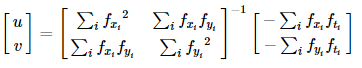


In [1]:
import numpy as np
import cv2 as cv

In [4]:
filename = 'slow_traffic_small.mp4'
cap = cv.VideoCapture(filename)

# Parámetros para la detección de esquinas de ShiTomasi
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parámetros para el algoritmo de Lucas-Kanade
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_COUNT | cv.TERM_CRITERIA_EPS, 10, 0.03))

# Creamos algunos colores aleatorios (para los marcadores)
color = np.random.randint(0,255,(100,3))

# Tomamos el primer frame y encontramos las esquinas en el mismo
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Creamos una máscara para dibujar sobre la misma (las estelas de colores)
mask = np.zeros_like(old_frame)

# Corremos el algoritmo sobre todos los frames
while True:
    ret,frame = cap.read()
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Calculamos el flujo óptico con LK (frame anterior, frame nuevo, características, parámetros)
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    
    # Elegimos las características "buenas" en el nuevo frame
    good_new = p1[st==1]
    good_old = p0[st==1]
    
    # Dibujamos las estelas de tracking
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv.line(mask, (int(a), int(b)),(int(c), int(d)), color[i].tolist(), 2)
        frame = cv.circle(frame,(int(a), int(b)),5,color[i].tolist(),-1)
        
    # Sumamos las estelas dibujadas sobre la máscara a la imagen actual
    img = cv.add(frame, mask)
    cv.imshow('frame',img)
    
    # Salimos cuando presione escape
    k = cv.waitKey(30) & 0xff
    if k == 27: # ESC
        break
        
    # Actualizamos el "frame viejo" al actual y las características a seguir
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv.destroyAllWindows()
cap.release()

### Dense Flow - Gunner Farneback

El método de Lucas-Kanade calcula el flujo óptico para un conjunto de características dispersas (en el ejemplo anterior, las esquinas detectadas mediante el algoritmo Shi-Tomasi). OpenCV proporciona otro algoritmo para encontrar el flujo óptico denso. Calcula el flujo óptico para todos los puntos del marco. Se basa en el algoritmo de Gunner Farneback que se explica en "Two-Frame Motion Estimation Based on Polynomial Expansion", Gunner Farneback en 2003.

El siguiente ejemplo muestra cómo encontrar el flujo óptico denso utilizando el algoritmo anterior. Obtenemos una matriz de 2 canales con vectores de flujo ópticos,( u , v ). Encontramos su magnitud y dirección. Codificamos con colores el resultado para una mejor visualización. 

- La dirección corresponde al tono (Hue) de la imagen
- La magnitud corresponde al valor (Value)

In [5]:
# Creamos el puntero al video
filename = 'slow_traffic_small.mp4'
#filename = 'vtest.avi'
cap = cv.VideoCapture(filename)
ret, frame1 = cap.read()

# Transformamos de color a grises el primer frame
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)

# Vamos a generar una imagen HSV donde representar el flujo. Vamos a utilizar:
# Canal S: todo en 255
# Canal H: Ángulo de la dirección de movimiento
# Canal V: Magnitud de la velocidad
hsv = np.zeros_like(frame1)
hsv[...,1] = 255 

# Corremos el algoritmo
while True:
    # Leemos el frame actual
    ret, frame2 = cap.read()
    next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
    
    # Calculamos el flujo óptico usando el algoritmo de Farneback
    flow = cv.calcOpticalFlowFarneback(prev=prvs,
                                      next=next,
                                      flow=None,
                                      pyr_scale=0.5,
                                      levels=3,
                                      winsize=15,
                                      iterations=3,
                                      poly_n=5,
                                      poly_sigma=1.2,
                                      flags=0)
    
    # A partir del flujo óptico obtenemos ángulo (dirección) y magnitud (velocidad)
    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
    
    # Convertimos ahora la imagen HSV a BGR para mostrarla
    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
    cv.imshow('frame2',bgr)
    
    # Si presionamos escape salimos. Si apretamos 's' grabamos el frame actual y la imagen de flujo óptico
    k = cv.waitKey(30) & 0xff
    if k == ord('q'):
        break
    elif k == ord('s'):
        cv.imwrite('opticalfb.png',frame2)
        cv.imwrite('opticalhsv.png',bgr)
    
    # Actualizamos el frame para el próximo paso del seguimiento
    prvs = next

cv.destroyAllWindows()
cap.release()